# Sentiment Analysis in Python

In This notebook I will be doing some sentiment analysis in python using differernt techniques:

1. VADER (Valence Aware Dictionary and Sentiment Reasoner) - Bag of words approach
2. TD-IDF
2. Roberta Pretrained Model from Huggingface
3. Huggingface pipeline

# Step 0. Read in Data and NLTK Basics

## Read data into DataFrame

In this code, I parse a dataset from a file `(movies.txt)` and extract relevant information into a pandas DataFrame. The extracted features include `review/score`, which represents the rating of the product; `review/helpfulness`, which is split into two columns (`helpfulness_numerator` and `helpfulness_denominator`) to capture the ratio of helpful votes to total votes for a review; and `review/text`, providing the plaintext content of the review. This preprocessing results in a structured DataFrame that focuses on key aspects for further analysis or sentiment analysis.

In [ ]:
import torch

torch.mps.empty_cache()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [ ]:
import pandas as pd

file_path = 'movies.txt'

# Create empty lists to store extracted information
text_list = []
score_list = []
helpfulness_numerator_list = []
helpfulness_denominator_list = []

with open(file_path, 'r', encoding='ISO-8859-1') as file:
    current_item = {}
    for line in file:
        line = line.strip()
        if ': ' in line:
            key, value = line.split(': ', 1)
            current_item[key] = value
        elif current_item:  # Check if the current item is not empty
            # Check if the current item has the required keys
            if all(key in current_item for key in ['review/text', 'review/score', 'review/helpfulness']):
                text_list.append(current_item['review/text'])
                score_list.append(float(current_item['review/score']))
                numerator, denominator = map(int, current_item['review/helpfulness'].split('/'))
                helpfulness_numerator_list.append(numerator)
                helpfulness_denominator_list.append(denominator)
            # Reset the current item
            current_item = {}

# Create a DataFrame from the lists
df = pd.DataFrame({
    'review/text': text_list,
    'review/score': score_list,
    'helpfulness_numerator': helpfulness_numerator_list,
    'helpfulness_denominator': helpfulness_denominator_list
})

# Display the DataFrame
print(df.head())


                                         review/text  review/score  \
0  Synopsis: On the daily trek from Juarez, Mexic...           3.0   
1  THE VIRGIN OF JUAREZ is based on true events s...           3.0   
2  The scenes in this film can be very disquietin...           5.0   
3  THE VIRGIN OF JUAREZ (2006)<br />directed by K...           3.0   
4  Informationally, this SHOWTIME original is ess...           3.0   

   helpfulness_numerator  helpfulness_denominator  
0                      7                        7  
1                      4                        4  
2                      8                       10  
3                      1                        1  
4                      1                        1  


Size/Shape of the Data

In [ ]:
print(df.shape)

(7911634, 4)


Sampling Data Based on 'review/score'
The main operation of the code involves creating a new DataFrame (df_sample) by sampling 200 rows from each group defined by the 'review/score' column in an existing DataFrame (df). The groupby function is used to group the rows based on the unique values in the 'review/score' column.

In [ ]:
import pandas as pd

df_sample = df.groupby('review/score').apply(lambda x: x.sample(2000)).reset_index(drop=True)


In [ ]:
print(df_sample)

                                            review/text  review/score  \
0     Not the entire first season, just the first ep...           1.0   
1     The Mummy Returns is about 40 times worse than...           1.0   
2     I was highly disappointed with this.  Not the ...           1.0   
3     I thought this movie would be hilarious, but i...           1.0   
4     My mom bought this movie along with the origin...           1.0   
...                                                 ...           ...   
9995  Tango and Cash is fantastic. The movie is one ...           5.0   
9996  Long overdue, "Lonesome Dove" finally gets som...           5.0   
9997  Chuck Norris does his usual dry one liners whi...           5.0   
9998  Ignore the religious zealots. It's a pretty go...           5.0   
9999  As sad as it sounds, this was one of the first...           5.0   

      helpfulness_numerator  helpfulness_denominator  
0                         4                        5  
1            

Shape/Size of the df_sample

In [ ]:
print(f"Shape of the df_sample -  {df_sample.shape}")

Shape of the df_sample -  (10000, 4)


## EDA

Distribution of scores in the original dataset

In [ ]:
df["review/score"].value_counts()

review/score
5.0    4380535
4.0    1654800
3.0     791575
1.0     629328
2.0     455396
Name: count, dtype: int64

Dustribution of scores in the sampled dataset

In [ ]:
df_sample["review/score"].value_counts()

review/score
1.0    2000
2.0    2000
3.0    2000
4.0    2000
5.0    2000
Name: count, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

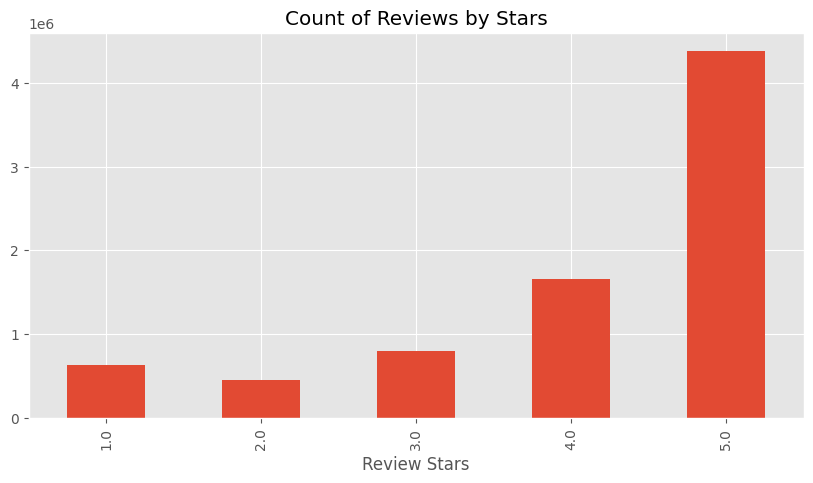

In [ ]:
ax = df["review/score"].value_counts().sort_index() \
    .plot(kind="bar",
          title="Count of Reviews by Stars",
          figsize=(10, 5))
ax.set_xlabel("Review Stars")
plt.show()

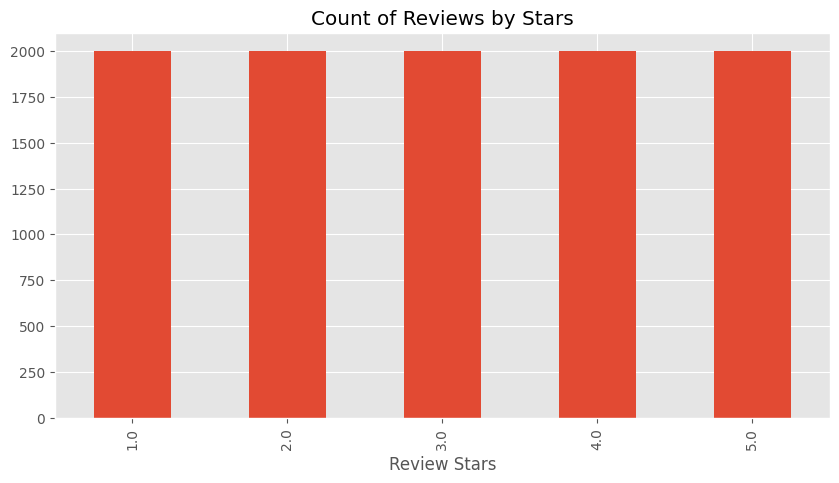

In [ ]:
ax = df_sample["review/score"].value_counts().sort_index() \
    .plot(kind="bar",
          title="Count of Reviews by Stars",
          figsize=(10, 5))
ax.set_xlabel("Review Stars")
plt.show()

It is clearly visible that original dataset was inbalanced and biased towards 5-star reviews, so by equally sampling the dataset, I made new dataset balanced.

## Basic NLTK

In [ ]:
example = df_sample["review/text"].iloc[50]
example_score = df_sample["review/score"].iloc[50]
print(example)
print(f"Example Score - {example_score}")

this was an awful movie it was creepy yes but the story line was just awful. i mean seriously a father and son that can astro project to an area that they call the beyond wtf could you be any more unoriginal.
Example Score - 1.0


In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['this', 'was', 'an', 'awful', 'movie', 'it', 'was', 'creepy', 'yes', 'but']

Downloading / installing nltk packages

In [ ]:
import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('this', 'DT'),
 ('was', 'VBD'),
 ('an', 'DT'),
 ('awful', 'JJ'),
 ('movie', 'NN'),
 ('it', 'PRP'),
 ('was', 'VBD'),
 ('creepy', 'JJ'),
 ('yes', 'RB'),
 ('but', 'CC')]

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  this/DT
  was/VBD
  an/DT
  awful/JJ
  movie/NN
  it/PRP
  was/VBD
  creepy/JJ
  yes/RB
  but/CC
  the/DT
  story/NN
  line/NN
  was/VBD
  just/RB
  awful/JJ
  ./.
  i/JJ
  mean/VBP
  seriously/RB
  a/DT
  father/NN
  and/CC
  son/NN
  that/WDT
  can/MD
  astro/VB
  project/NN
  to/TO
  an/DT
  area/NN
  that/IN
  they/PRP
  call/VBP
  the/DT
  beyond/IN
  wtf/NN
  could/MD
  you/PRP
  be/VB
  any/DT
  more/JJR
  unoriginal/JJ
  ./.)


# Step 1. VADER Sentiment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the negative/neutral/positive scores

- This uses a `"bag of words"` approach:

    1. Stop words are removed
    2. Each word is scored and combined to a total score.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia

In [ ]:
sia.polarity_scores("I am so happy!")

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
sia.polarity_scores("This is the worst thing ever.")

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
example

'this was an awful movie it was creepy yes but the story line was just awful. i mean seriously a father and son that can astro project to an area that they call the beyond wtf could you be any more unoriginal.'

In [ ]:
sia.polarity_scores(example)

{'neg': 0.264, 'neu': 0.699, 'pos': 0.037, 'compound': -0.9081}

Run the polarity score on the entire dataset

In [ ]:
res = {}
for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    text = row["review/text"]
    res[i] = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders.head()

,neg,neu,pos,compound
0,0.000,0.945,0.055,0.2724
1,0.172,0.754,0.074,-0.9127
2,0.259,0.741,0.000,-0.9359
3,0.220,0.718,0.062,-0.9386
4,0.077,0.779,0.144,0.7416


In [ ]:
# Merge based on the index
vaders = vaders.merge(df_sample, left_index=True, right_index=True, how="left")
vaders = vaders.reset_index().rename(columns={"index": "Id"})
# Display the merged DataFrame
vaders.head()


,Id,neg,neu,pos,compound,review/text,review/score,helpfulness_numerator,helpfulness_denominator
0,0,0.000,0.945,0.055,0.2724,"Not the entire first season, just the first ep...",1.0,4,5
1,1,0.172,0.754,0.074,-0.9127,The Mummy Returns is about 40 times worse than...,1.0,1,6
2,2,0.259,0.741,0.000,-0.9359,I was highly disappointed with this. Not the ...,1.0,0,0
3,3,0.220,0.718,0.062,-0.9386,"I thought this movie would be hilarious, but i...",1.0,3,10
4,4,0.077,0.779,0.144,0.7416,My mom bought this movie along with the origin...,1.0,5,11


## Plot VADER results

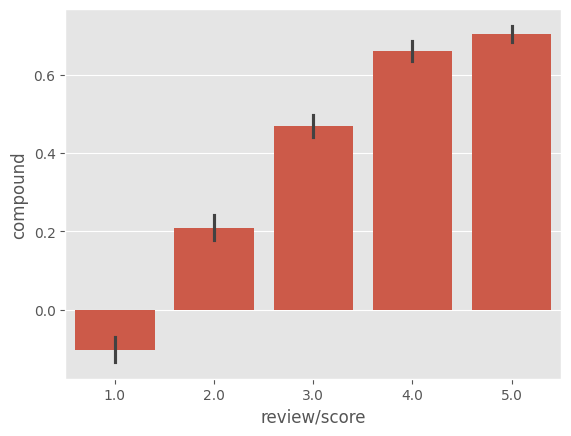

In [ ]:
sns.barplot(data=vaders, x="review/score", y="compound")
ax.set_title("Compound Score by Amazon Star Review")
plt.show()

1 star review has lower compound score and 5 star review has higher. And this is exactly what we expect. The more positive the compund becomes by which score was givent the more positive text respectively.

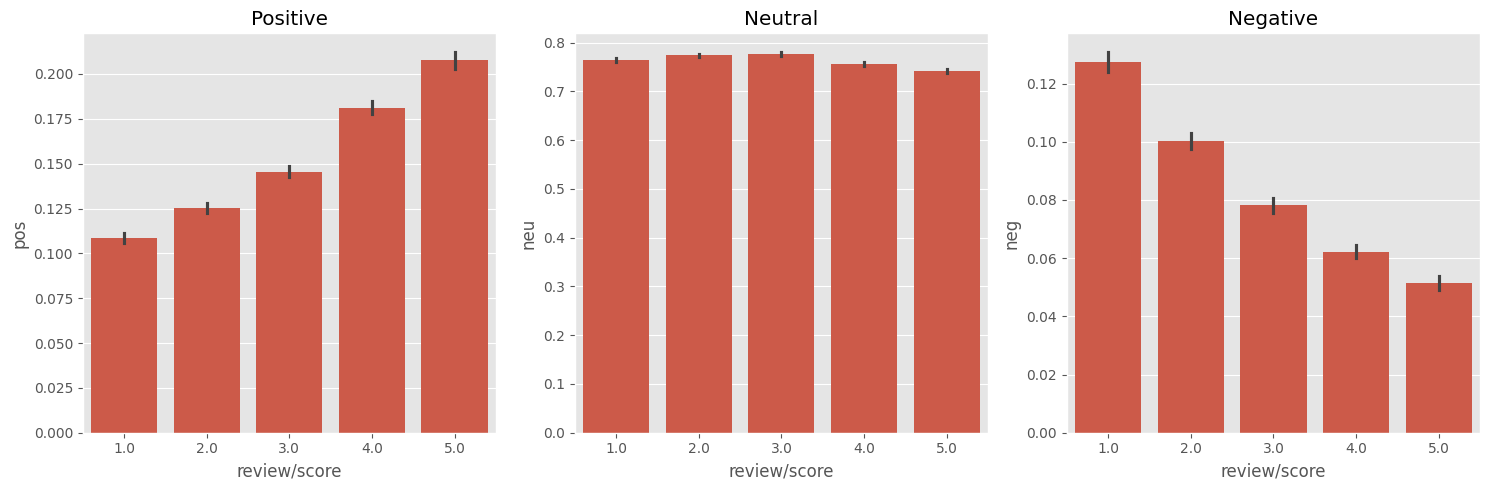

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=vaders, x="review/score", y="pos", ax=axs[0])
sns.barplot(data=vaders, x="review/score", y="neu", ax=axs[1])
sns.barplot(data=vaders, x="review/score", y="neg", ax=axs[2])

axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")

plt.tight_layout()

plt.show()

### Define Features and Target Variables

`Features`: The text of the reviews represented by

 - neg,
 - neu,
 - pos,
 - compound.


`Targets`:

 - review/score,
 - helpfulness_numerator,
 - helpfulness_denominator.

### Predicting Helpfulness by Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = vaders[['neg', 'neu', 'pos', 'compound']]
y_helpful = vaders[['helpfulness_numerator', 'helpfulness_denominator']]

# Split the data into training and testing sets
X_train, X_test, y_train_helpful, y_test_helpful = train_test_split(X, y_helpful, test_size=0.2, random_state=42)

# Use a Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)

# Train the model
regressor.fit(X_train, y_train_helpful)

# Make predictions
y_pred_helpful = regressor.predict(X_test)

# Evaluate the regression model
mse_numerator = mean_squared_error(y_test_helpful['helpfulness_numerator'], y_pred_helpful[:, 0])
r2_numerator = r2_score(y_test_helpful['helpfulness_numerator'], y_pred_helpful[:, 0])

mse_denominator = mean_squared_error(y_test_helpful['helpfulness_denominator'], y_pred_helpful[:, 1])
r2_denominator = r2_score(y_test_helpful['helpfulness_denominator'], y_pred_helpful[:, 1])

print('Regression Metrics for Helpful Votes:')
print(f'MSE for Numerator: {mse_numerator:.2f}')
print(f'R2 Score for Numerator: {r2_numerator:.2f}')
print(f'MSE for Denominator: {mse_denominator:.2f}')
print(f'R2 Score for Denominator: {r2_denominator:.2f}')


Regression Metrics for Helpful Votes:
MSE for Numerator: 312.12
R2 Score for Numerator: -0.05
MSE for Denominator: 578.58
R2 Score for Denominator: -0.04


### Improvement -> Use TF-IDF and Classification

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_text = df_sample['review/text']
y_helpful = df_sample['helpfulness_numerator'] > df_sample['helpfulness_denominator'] / 2  # Binary classification: helpful or not

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_text, y_helpful, test_size=0.2, random_state=42)

# Use TF-IDF to convert text data into numeric features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a simple logistic regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.67


My model predicted the helpfulness of the review 67% accurate

### Predicting Score

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

X = vaders[['neg', 'neu', 'pos', 'compound']]
y_review_score = vaders['review/score'].values.astype(int) - 1  # Convert to 0-based indexing

# Split the data into training and testing sets
X_train, X_test, y_train_review, y_test_review = train_test_split(X, y_review_score, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train_review)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test_review)

In [ ]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 8
output_size = 5  # 5 classes for review scores

model = SimpleNeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert labels to one-hot encoding
y_train_onehot = torch.zeros(len(y_train_review), 5)
y_train_onehot.scatter_(1, y_train_tensor.unsqueeze(1), 1)



tensor([[0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])

In [ ]:
from tqdm import tqdm

# Train the model
epochs = 1000
batch_size = 32

for epoch in range(epochs):
    # Use tqdm to display a progress bar for each epoch
    with tqdm(total=len(X_train_tensor), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i + batch_size]
            batch_y = y_train_tensor[i:i + batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            # Update the progress bar
            pbar.update(batch_size)
            pbar.set_postfix({'Loss': loss.item()})




Epoch 1000/1000: 100%|██████████| 8000/8000 [00:00<00:00, 37794.65batch/s, Loss=1.49]


In [ ]:
# Evaluate the model
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    _, y_pred_review = torch.max(outputs, 1)

# Convert PyTorch tensor to NumPy array
y_pred_review = y_pred_review.numpy()

# Evaluate the classification model
accuracy_review = accuracy_score(y_test_review, y_pred_review)
f1_review = f1_score(y_test_review, y_pred_review, average='weighted')
confusion_mat_review = confusion_matrix(y_test_review, y_pred_review)

print('Classification Metrics for Review Score:')
print(f'Accuracy: {accuracy_review:.2f}')
print(f'F1 Score: {f1_review:.2f}')
print('Confusion Matrix:')
print(confusion_mat_review)

print(f'y_test_review: {y_test_review}')
print(f'y_pred_review: {y_pred_review}')

Classification Metrics for Review Score:
Accuracy: 0.34
F1 Score: 0.32
Confusion Matrix:
[[251  85  22  22  30]
 [163 103  55  42  30]
 [114  66  54  89  72]
 [ 65  56  64  78 152]
 [ 62  38  35  61 191]]
y_test_review: [3 2 0 ... 3 0 3]
y_pred_review: [2 0 0 ... 4 0 0]


# Improvements for predicting Score

# Step 2. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

VADER results on example

In [ ]:
print(example)
sia.polarity_scores(example)

this was an awful movie it was creepy yes but the story line was just awful. i mean seriously a father and son that can astro project to an area that they call the beyond wtf could you be any more unoriginal.


{'neg': 0.264, 'neu': 0.699, 'pos': 0.037, 'compound': -0.9081}

Run for Roberta Model

In [ ]:
encoded_text = tokenizer(example, return_tensors="pt")
encoded_text

{'input_ids': tensor([[    0,  9226,    21,    41, 11522,  1569,    24,    21, 23814,  4420,
            53,     5,   527,   516,    21,    95, 11522,     4,   939,  1266,
          3640,    10,  1150,     8,   979,    14,    64, 12976,  1001,   695,
             7,    41,   443,    14,    51,   486,     5,  1684,   885, 41407,
           115,    47,    28,   143,    55,   542, 34545,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]])}

In [ ]:
output = model(**encoded_text)
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.3281, -0.6883, -2.7354]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

This code snippet processes sentiment scores generated by a model. The raw scores are extracted, passed through a softmax function to obtain probabilities, and then organized into a dictionary. The dictionary, scores_dict, provides a breakdown of sentiment probabilities for negative, neutral, and positive categories. Finally, the dictionary is printed for quick inspection of sentiment predictions.

In [ ]:
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    "roberta_neg" : scores[0],
    "roberta_neu" : scores[1],
    "roberta_pos" : scores[2],
}
print(scores_dict)

{'roberta_neg': 0.9800617, 'roberta_neu': 0.017658379, 'roberta_pos': 0.002279858}


This function, polarity_scores_roberta, performs sentiment analysis using a pre-trained RoBERTa model. Given an input example, it tokenizes the text, obtains model predictions, and extracts sentiment scores. The function returns a dictionary, scores_dict, with sentiment probabilities for negative, neutral, and positive categories based on the RoBERTa model. This enables easy interpretation and analysis of sentiment in the provided text.

In [ ]:
import torch

def polarity_scores_roberta(example):
    # Ensure the model is in evaluation mode
    model.eval()

    # Tokenize the input
    encoded_text = tokenizer(example, return_tensors='pt')

    # Get the model output
    with torch.no_grad():
        output = model(**encoded_text)

    # Extract scores
    logits = output.logits
    scores = torch.nn.functional.softmax(logits, dim=-1).squeeze().numpy()

    # Map scores to dictionary
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict


In [ ]:
polarity_scores_roberta(example)

{'roberta_neg': 0.9800617,
 'roberta_neu': 0.017658379,
 'roberta_pos': 0.002279858}

In this code snippet, sentiment analysis is performed on a sample DataFrame (df_sample) using both VADER sentiment analysis (sia) and a RoBERTa-based model (polarity_scores_roberta). The results are combined into a dictionary (both) for each text entry. The loop iterates over the DataFrame, and for each row, it extracts the text, applies VADER sentiment analysis, and RoBERTa sentiment analysis. The final results are stored in a dictionary (res). Any potential errors, such as runtime errors or index errors, are caught and ignored during the process.

In [ ]:
res = {}
for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    try:
        text = row["review/text"]
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[i] = both
    except (RuntimeError, IndexError) as e:
        pass

100%|██████████| 10000/10000 [11:09<00:00, 14.93it/s]


This code creates a DataFrame (results_df) by transposing the previously obtained sentiment analysis results (res). The DataFrame is then merged with the original sample DataFrame (df_sample) based on their indices. Finally, the resulting DataFrame is reset, and the index is renamed to "Id" for clarity in further analysis or presentation.

In [ ]:
results_df = pd.DataFrame(res).T
# Merge based on the index
results_df = results_df.merge(df_sample, left_index=True, right_index=True, how="left")
results_df = results_df.reset_index().rename(columns={"index": "Id"})


In [ ]:
# Display the merged DataFrame
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,review/text,review/score,helpfulness_numerator,helpfulness_denominator
0,0,0.000,0.945,0.055,0.2724,0.144989,0.402610,0.452401,"Not the entire first season, just the first ep...",1.0,4,5
1,1,0.172,0.754,0.074,-0.9127,0.979663,0.017521,0.002815,The Mummy Returns is about 40 times worse than...,1.0,1,6
2,2,0.259,0.741,0.000,-0.9359,0.975616,0.021152,0.003232,I was highly disappointed with this. Not the ...,1.0,0,0
3,3,0.220,0.718,0.062,-0.9386,0.970703,0.025007,0.004289,"I thought this movie would be hilarious, but i...",1.0,3,10
4,4,0.077,0.779,0.144,0.7416,0.829679,0.145764,0.024557,My mom bought this movie along with the origin...,1.0,5,11


## Step 3. Combine and compare

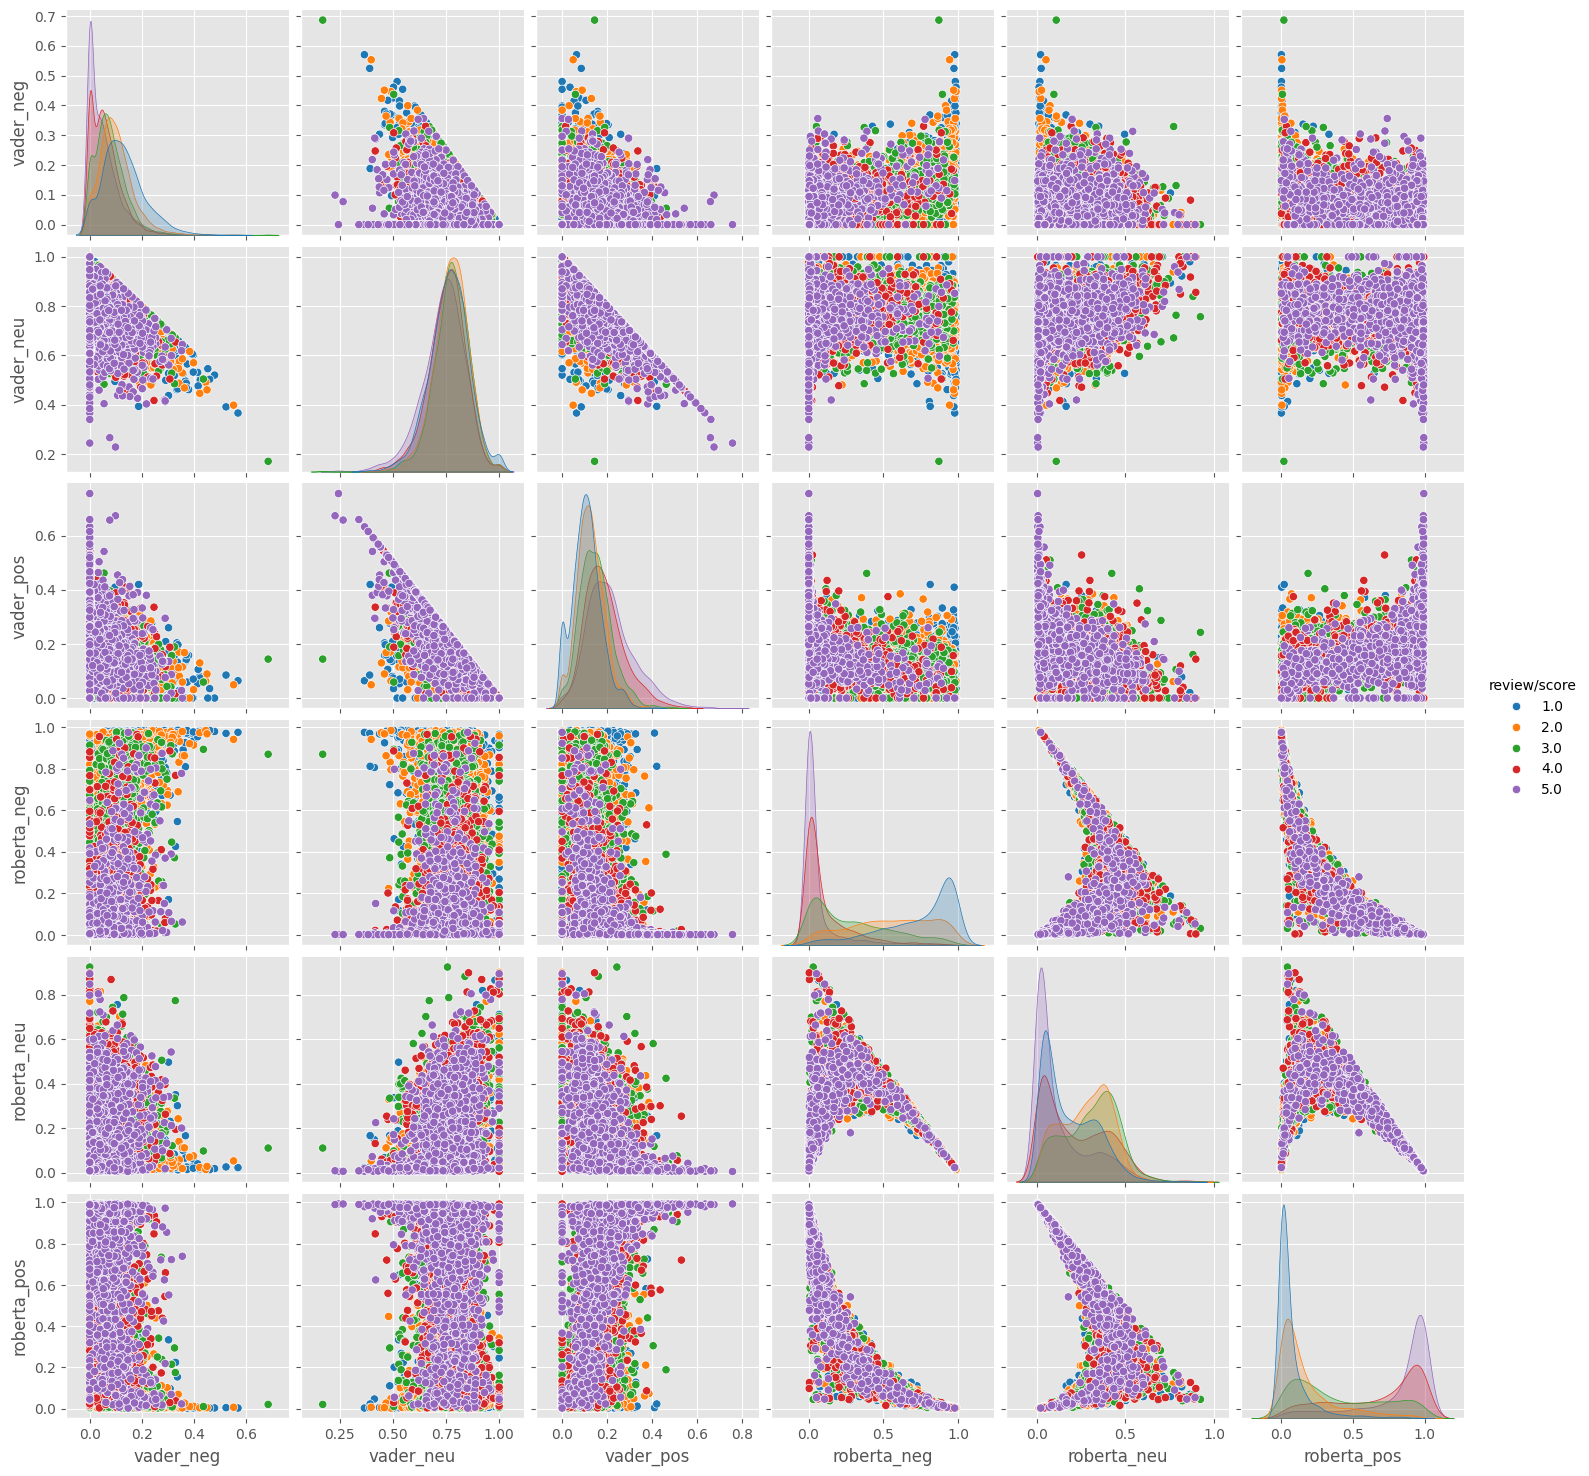

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='review/score',
            palette='tab10')
plt.show()

## Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
result = results_df.query("`review/score` == 1") \
    .sort_values('roberta_pos', ascending=False)['review/text'].values[0]


In [ ]:
result

'Having loved The Tin Drum, I anticipated this feature greatly. Having seen it, I would recommend watching The Tin Drum again.'

Let's look at vaders

In [ ]:
result = results_df.query("`review/score` == 1") \
    .sort_values('vader_pos', ascending=False)['review/text'].values[0]

In [ ]:
result

"An &quot;alternate miss world&quot; video with host Divine. Divine isn't  funny and the competition has no talent. Divine fans beware!"

Negative sentiment 5-Star review

In [ ]:
result = results_df.query("`review/score` == 5") \
    .sort_values('roberta_neg', ascending=False)['review/text'].values[0]


In [ ]:
result

'I hate that little girl! Some of those old movies are still creepier than any slasher film made today and this is one of them.'

In [ ]:
result = results_df.query("`review/score` == 5") \
    .sort_values('vader_neg', ascending=False)['review/text'].values[0]


In [ ]:
result

'I taught a abuse and neglect college course and showed this video to my class.  WOW..great video.'

## Step 5: The Transformers Pipeline

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
sent_pipeline('some neutral sentence')

[{'label': 'NEGATIVE', 'score': 0.9742957949638367}]

This code defines a function map_to_sentiment_class that takes a numerical label as input and maps it to a sentiment class. It categorizes labels 1 and 2 as 'NEGATIVE', label 3 as 'NEUTRAL', labels 4 and 5 as 'POSITIVE', and any other label as 'UNKNOWN'.

In [ ]:
def map_to_sentiment_class(label):
    if label in [1, 2]:
        return 'NEGATIVE'
    elif label == 3:
        return 'NEUTRAL'
    elif label in [4, 5]:
        return 'POSITIVE'
    else:
        return 'UNKNOWN'

In [ ]:
# Apply the sentiment analysis pipeline to the reviews
df_sample['sentiment_pred'] = df_sample['review/text'].apply(lambda x: sent_pipeline(x[:512])[0]['label'])  # Truncate to 512 tokens

# Map the original labels to sentiment classes
df_sample['ground_truth_sentiment'] = df_sample['review/score'].apply(map_to_sentiment_class)

# Calculate accuracy
accuracy = (df_sample['sentiment_pred'] == df_sample['ground_truth_sentiment']).mean()

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 67.46%


In [ ]:
df_sample['ground_truth_sentiment'].unique()

array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object)

In [ ]:
df_sample['sentiment_pred'].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

This pipeline gave 67.46% accuracy because it does not have Neutral option, which means it ignored all 3 star reviews

## Step 6: RoBERTa Model with Pipeline

In [ ]:
from transformers import pipeline, AutoTokenizer

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


In [ ]:
def map_to_sentiment_class(label):
    if label in [1, 2]:
        return 'LABEL_0'
    elif label == 3:
        return 'LABEL_1'
    elif label in [4, 5]:
        return 'LABEL_2'
    else:
        return 'UNKNOWN'

In [ ]:
# Apply the sentiment analysis pipeline to the reviews
df_sample['sentiment_pred'] = df_sample['review/text'].apply(lambda x: classifier(x[:512])[0]['label'])  # Truncate to 512 tokens


In [ ]:
df_sample['sentiment_pred']

0       LABEL_2
1       LABEL_0
2       LABEL_0
3       LABEL_0
4       LABEL_0
         ...   
9995    LABEL_2
9996    LABEL_0
9997    LABEL_2
9998    LABEL_2
9999    LABEL_2
Name: sentiment_pred, Length: 10000, dtype: object

In [ ]:
# Map the original labels to sentiment classes
df_sample['ground_truth_sentiment'] = df_sample['review/score'].apply(map_to_sentiment_class)

In [ ]:
df_sample['ground_truth_sentiment']

0       LABEL_0
1       LABEL_0
2       LABEL_0
3       LABEL_0
4       LABEL_0
         ...   
9995    LABEL_2
9996    LABEL_2
9997    LABEL_2
9998    LABEL_2
9999    LABEL_2
Name: ground_truth_sentiment, Length: 10000, dtype: object

In [ ]:
# Calculate accuracy
accuracy = (df_sample['sentiment_pred'] == df_sample['ground_truth_sentiment']).mean()

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 64.88%


This gave me accuracy of 64.88%. As even better improvement in my future analysis I would fineTune this model and use Trainer to train on my own dataset.


# Sentiment Analysis Notebook Summary
### Overview
This Jupyter Notebook conducts sentiment analysis on a movie review dataset employing various techniques, including VADER, TF-IDF, RoBERTa pre-trained models from Hugging Face, Hugging Face pipeline, and Hugging Face DistilBERT. The analysis encompasses data preprocessing, exploratory data analysis (EDA), and the implementation of diverse sentiment analysis methodologies.

### Data Preprocessing
- Reads data from 'movies.txt' and structures it into a Pandas DataFrame.
- DataFrame includes key columns: review/text, review/score, helpfulness_numerator, and helpfulness_denominator.

### Exploratory Data Analysis (EDA)
- Investigates the distribution of review scores in the original dataset.
- Achieves dataset balance by sampling 2000 rows from each 'review/score' group.

### VADER Sentiment Analysis
- Utilizes NLTK's SentimentIntensityAnalyzer for sentiment analysis.
- Computes negative, neutral, and positive sentiment scores for each review.
- Visualizes sentiment analysis results using bar plots.

### TF-IDF and Classification
- Applies TF-IDF to convert text data into numerical features.
- Trains a logistic regression model for predicting review helpfulness.

### Regression Model
- Implements a Random Forest Regressor to predict helpfulness numerator and denominator.
- Evaluates the model using mean squared error and R2 score.


### Simple Neural Network for Review Score Prediction
- Constructs a PyTorch-based neural network to predict review scores.
- Evaluates the classification model using accuracy, F1 score, and confusion matrix.

### RoBERTa Pre-trained Model
- Utilizes a RoBERTa pre-trained model from Hugging Face for sentiment analysis.
- Compares VADER sentiment scores with RoBERTa scores.
- Visualizes sentiment scores using pair plots.

### Transformers Pipeline
- Uses the Hugging Face pipeline for sentiment analysis and assesses accuracy.
- Demonstrates the pipeline's limitation in handling neutral sentiments.

### RoBERTa Model with Pipeline
- Utilizes RoBERTa pre-trained model with a pipeline for sentiment analysis.
- Maps sentiment labels to classes for comparison.
- Calculates accuracy based on predicted and ground truth sentiment labels.

This notebook provides a comprehensive sentiment analysis using diverse methodologies, facilitating a thorough comparison of their performance on the given movie review dataset.
It reaches 67% accuracy for predicting the helpfulness of the review and 67.46% of accuracy to predict the score.